In [78]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr 
import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random as random
stock_ticker = pdr.get_data_yahoo('AMZN', start = datetime.datetime(2017, 1, 1), end = datetime.datetime(2020, 12, 31))


In [79]:
class stock_Dataset(torch.utils.data.Dataset):
  #torch Dataset class; intermediary between raw data and torch dataloader
    def __init__(self, inputs, outputs):

        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self):
        return len(self.outputs)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.inputs[idx])
        y = torch.FloatTensor([self.outputs[idx]])
        return (x, y)

def transform_data(data_frame, history_days, training_split):

  #add two technical indicators
  data_frame['Close_Long_Moving_Average'] = data_frame['Close'].rolling(window=50).mean()
  data_frame['Close_Short_Moving_Average']= data_frame['Close'].rolling(window=10).mean()
  data_frame = data_frame.dropna()

  #scale the close column individually so we can rescale normalized predictions later
  n = int(training_split*len(data_frame['Open']))
  close_scaler = preprocessing.MinMaxScaler()
  close_training = data_frame.iloc[:n]['Close'].values
  close_training = np.expand_dims(close_training, -1)
  close_training = close_scaler.fit_transform(close_training)
    
  #now scale the entire frame  
  training_data = data_frame.iloc[:n]
  data_scaler = preprocessing.MinMaxScaler()
  training_data = data_scaler.fit_transform(training_data)
  data_frame_normalized = data_scaler.transform(data_frame)
  #make a numpy array of next day closing value, starting at index 30 
  #we want to be sure that the "next" day is relative to the thirty day history stored at the same index in histories
  next_day_close_values_normalized = np.array([data_frame_normalized[i+history_days][1].copy() for i in range(len(data_frame_normalized)-history_days)])
  next_day_close_values_normalized = np.expand_dims(next_day_close_values_normalized, -1)
  #get thirty day history starting with indices 0-29
  histories_normalized = np.array([data_frame_normalized[i : i+history_days].copy() for i in range(len(data_frame_normalized)-history_days)])
  data_frame_normalized = pd.DataFrame(data_frame_normalized, columns = data_frame.columns, index = data_frame.index)

  return close_scaler, data_scaler, data_frame_normalized, histories_normalized, next_day_close_values_normalized

def dataset_to_dataloader(x, y, params):
  #get torch dataloader using Dataset class
  training_set = stock_Dataset(x, y)
  training_generator = torch.utils.data.DataLoader(training_set, **params)
  return training_generator  

class LSTM(nn.Module):
    #define model architecture
    def __init__(self, input_dim, hidden_dim, batches, output_dim=1,
                    num_layers=1):
      super(LSTM, self).__init__()
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.batches = batches
      self.num_layers = num_layers
 
      self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
 
      self.linear = nn.Linear(self.hidden_dim, output_dim)
      self.hidden = (torch.zeros(self.num_layers, self.batches, self.hidden_dim),
                torch.zeros(self.num_layers, self.batches, self.hidden_dim))  
    #forward method
    def forward(self, input):
      lstm_out, self.hidden = self.lstm(input, self.hidden)
      y_pred = self.linear(lstm_out[-1])
      return y_pred.view(self.batches)
    #method to initalize hidden state; this is a stateless model!
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batches, self.hidden_dim),
                torch.zeros(self.num_layers, self.batches, self.hidden_dim))    
    
def train_model(model, epochs, input_data, learning_rate, batch_size):
  #choose loss function, optimizer, then run through epochs
  loss_fn = torch.nn.MSELoss()
 
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
  hist = np.zeros(epochs)
  i = 0
  for t in range(epochs):
    for seq, labels in input_data:
      #reshape data
      seq = seq.view(30, batch_size, 8)
      labels = labels.view(batch_size)
    
      #zero the gradient, initalize hidden state, and make forward pass
      model.zero_grad()
      model.hidden = model.init_hidden()
      y_pred = model(seq)

      loss = loss_fn(y_pred, labels)
        
      hist[t] = loss.item()
 

      optimizer.zero_grad()
 

      loss.backward()
 

      optimizer.step()
    
      i+= 1
      if i%100 == 0:
        print(t)
        
def generate_predictions(test_dataloader, model, batch_size):
  #generate predictions on test data
    y_pred = []

    model.eval()
    for seq, labels in test_dataloader:
      seq = seq.view(30, batch_size, 8)
      with torch.no_grad():
        model.hidden = model.init_hidden()
        pred = model(seq)
        pred.detach()
        pred = pred.numpy()   
        #have to loop through each pred in case of batch_size>1
        for element in range(len(pred)):
          individual = pred[element]
          y_pred.append(individual) 
    return y_pred 

def show_model(y_pred, real_data):
  #plot real price movement against predictions
    plt.gcf().set_size_inches(22, 17, forward=True)

    start = 0
    end = -1

    real = plt.plot(real_data[start:end], label='real')
    pred = plt.plot(y_pred[start:end], label='predicted')

    plt.legend(['Real', 'Predicted'])

    plt.show()  
    
def reconvert(y_pred, output_scaler):
  #reconvert normalized data to unnormalized data
    x = len(y_pred)
    y_pred = np.reshape(y_pred, (x, 1))
    return output_scaler.inverse_transform(y_pred)     

In [80]:
#define our training split, batch_size, lookback period
training_split = 0.85
batch_size = 5
training_cutoff_index = int(training_split*len(stock_ticker['Open']))
history_days = 30
print(stock_ticker[:30])

                  High         Low  ...    Volume   Adj Close
Date                                ...                      
2017-01-03  758.760010  747.700012  ...   3521100  753.669983
2017-01-04  759.679993  754.200012  ...   2510500  757.179993
2017-01-05  782.400024  760.260010  ...   5830100  780.450012
2017-01-06  799.440002  778.479980  ...   5986200  795.989990
2017-01-09  801.770020  791.770020  ...   3446100  796.919983
2017-01-10  798.000000  789.539978  ...   2558400  795.900024
2017-01-11  799.500000  789.510010  ...   2992800  799.020020
2017-01-12  814.130005  799.500000  ...   4873900  813.640015
2017-01-13  821.650024  811.400024  ...   3791900  817.140015
2017-01-17  816.000000  803.440002  ...   3670500  809.719971
2017-01-18  811.729980  804.270020  ...   2354200  807.479980
2017-01-19  813.510010  807.320007  ...   2540800  809.039978
2017-01-20  816.020020  806.260010  ...   3376200  808.330017
2017-01-23  818.500000  805.080017  ...   2797500  817.880005
2017-01-

In [81]:
#get our scalers, numpy arrays, and normalized dataframe
close_scaler, data_scaler, data_frame_normalized, histories_normalized, next_day_close_values_normalized = transform_data(stock_ticker, 30, 0.75)
print(len(next_day_close_values_normalized))
print(len(histories_normalized))


928
928


In [82]:
#separate numpy arrays into training and test
histories_normalized_training = histories_normalized[:training_cutoff_index].copy()
next_day_close_values_normalized_training = next_day_close_values_normalized[:training_cutoff_index].copy()

#we shave off a few data points so that the # of data points is divisible by batch size; otherwise we 
#get a hanging batch at the end with the wrong size
training_shave_off = (histories_normalized_training.shape[0] % batch_size) 
if training_shave_off != 0:
  histories_normalized_training = histories_normalized_training[:-training_shave_off]
  next_day_close_values_normalized_training = next_day_close_values_normalized_training[:-training_shave_off]

#convert to list and create dataloader
input_list = histories_normalized_training.tolist()
output_list = next_day_close_values_normalized_training.tolist()
params = {"batch_size": 5, "shuffle": False}
training_dataloader = dataset_to_dataloader(input_list, output_list, params)

#same stuff on test data
histories_normalized_test = histories_normalized[training_cutoff_index:].copy()
next_day_close_values_normalized_test = next_day_close_values_normalized[training_cutoff_index:].copy()

test_shave_off = (histories_normalized_test.shape[0] % batch_size) 
if test_shave_off != 0:
  histories_normalized_test = histories_normalized_test[:-test_shave_off]
  next_day_close_values_normalized_test = next_day_close_values_normalized_test[:-test_shave_off]

input_list_test = histories_normalized_test.tolist()
output_list_test = next_day_close_values_normalized_test.tolist()
params = {"batch_size": 5, "shuffle": False}
test_dataloader = dataset_to_dataloader(input_list_test, output_list_test, params)

In [83]:
model = LSTM(8, 100, 5)
print(model)


LSTM(
  (lstm): LSTM(8, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [84]:
train_model(model, 120, training_dataloader, 0.0001, 5)

0
1
1
2
2
3
4
4
5
5
6
7
7
8
8
9
9
10
11
11
12
12
13
14
14
15
15
16
16
17
18
18
19
19
20
21
21
22
22
23
23
24
25
25
26
26
27
28
28
29
29
30
30
31
32
32
33
33
34
35
35
36
36
37
38
38
39
39
40
40
41
42
42
43
43
44
45
45
46
46
47
47
48
49
49
50
50
51
52
52
53
53
54
54
55
56
56
57
57
58
59
59
60
60
61
61
62
63
63
64
64
65
66
66
67
67
68
69
69
70
70
71
71
72
73
73
74
74
75
76
76
77
77
78
78
79
80
80
81
81
82
83
83
84
84
85
85
86
87
87
88
88
89
90
90
91
91
92
92
93
94
94
95
95
96
97
97
98
98
99
99
100
101
101
102
102
103
104
104
105
105
106
107
107
108
108
109
109
110
111
111
112
112
113
114
114
115
115
116
116
117
118
118
119
119


In [85]:
y_pred = generate_predictions(test_dataloader, model, 5)

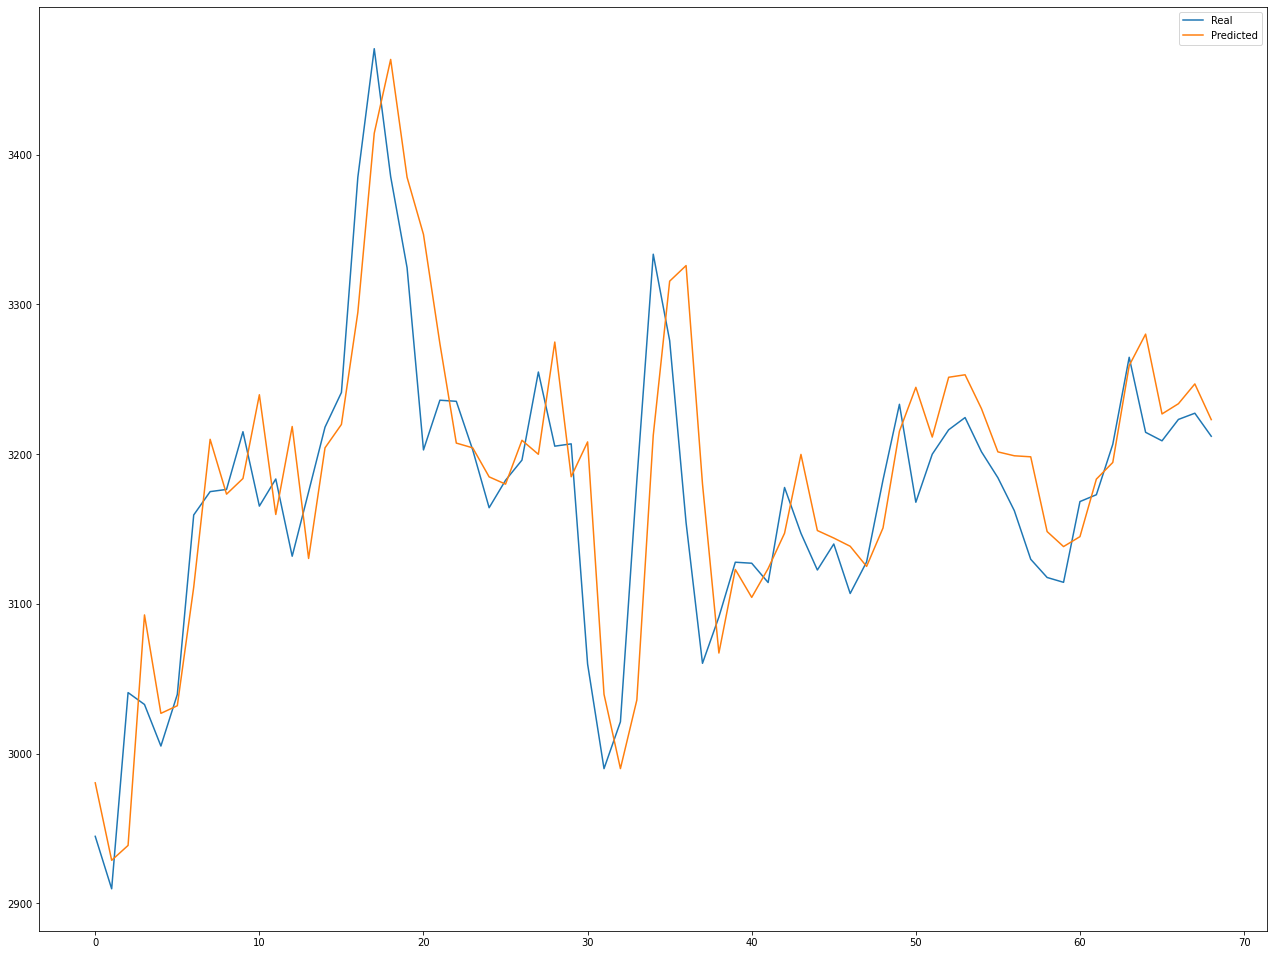

In [86]:
y_pred = reconvert(y_pred, close_scaler)
next_day_close_values_test = next_day_close_values_normalized[training_cutoff_index:]
next_day_close_values_test = reconvert(next_day_close_values_normalized_test, close_scaler)
show_model(y_pred, next_day_close_values_test)

In [87]:
#simple trading strategy on 70 test days using model, long only
#create histories data as numpy array; dataloader provides tensors so a bit annoying
histories_test = np.array([stock_ticker[i : i+history_days].copy() for i in range(len(stock_ticker)-history_days)])
histories_test = histories_test[training_cutoff_index:]
shave_off = histories_test.shape[0] %batch_size

if shave_off != 0:
  histories_test = histories_test[:-shave_off]

capital = 1000000
position = 0
invested = False 
position_value = 0
for i in range(len(y_pred)-1):
    tomorrow_close_proj = y_pred[i+1]
    tomorrow_open_real = histories_test[i+1][29][2]
    today_close_real = histories_test[i][29][3]
    if tomorrow_close_proj < today_close_real and invested == True:
        position_value = position * tomorrow_open_real
        capital = capital + position_value
        position = 0
        invested = False
    if tomorrow_close_proj > today_close_real and invested == False:
        position = int(capital/tomorrow_open_real)
        position_value = position*tomorrow_open_real
        capital = capital - position_value
        invested = True
print(capital)       

1363447.2424316406


In [88]:
#buy and hold
position = int(1000000/histories_test[0][29][2])
position_final_value = position * histories_test[69][29][3]
print(position_final_value)

1068367.96875
